### EDA

In [328]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date, time, timedelta
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
#importing over and undersampling algorithms from imblearn (you will have to manually install it in your envoirenment with pip install imblearn) 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder


In [329]:
data = pd.read_csv('./data/training.csv')
data_test = pd.read_csv('./data/test.csv')
test_id = data_test.TransactionId

In [330]:
test_id

0         TransactionId_50600
1         TransactionId_95109
2         TransactionId_47357
3         TransactionId_28185
4         TransactionId_22140
                 ...         
45014    TransactionId_116198
45015     TransactionId_24829
45016    TransactionId_102920
45017    TransactionId_128439
45018     TransactionId_45927
Name: TransactionId, Length: 45019, dtype: object

In [331]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 non-null  int64  
 15  FraudResult        

In [332]:
data.describe()

,CountryCode,Amount,Value,PricingStrategy,FraudResult
count,95662.0,9.566200e+04,9.566200e+04,95662.000000,95662.000000
mean,256.0,6.717846e+03,9.900584e+03,2.255974,0.002018
std,0.0,1.233068e+05,1.231221e+05,0.732924,0.044872
min,256.0,-1.000000e+06,2.000000e+00,0.000000,0.000000
25%,256.0,-5.000000e+01,2.750000e+02,2.000000,0.000000
50%,256.0,1.000000e+03,1.000000e+03,2.000000,0.000000
75%,256.0,2.800000e+03,5.000000e+03,2.000000,0.000000
max,256.0,9.880000e+06,9.880000e+06,4.000000,1.000000


In [333]:
#sns.pairplot(data)

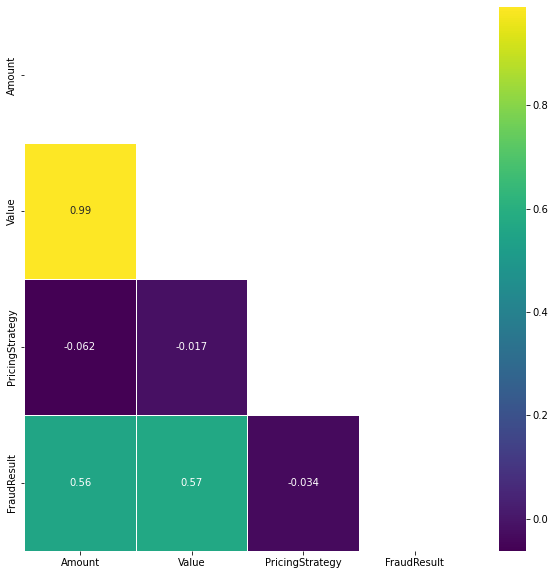

In [334]:
# plotting the correlation matrix on the given data to see how each column correlates to another
fraud_data = data.drop(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'CurrencyCode', 'CountryCode'], axis = 1)
plt.figure(figsize=(10, 10))
matrix = np.triu(fraud_data.corr())
sns.heatmap(fraud_data.corr(), annot=True,
            linewidth=.8, mask=matrix, cmap="viridis");

In [335]:
# Convert time to datatime format
data['TransactionStartTime'] = pd.to_datetime(data['TransactionStartTime'], format='%Y-%m-%dT%H:%M:%SZ')
data['Hour'] = data['TransactionStartTime'].dt.hour

data_test['TransactionStartTime'] = pd.to_datetime(data_test['TransactionStartTime'], format='%Y-%m-%dT%H:%M:%SZ')
data_test['Hour'] = data_test['TransactionStartTime'].dt.hour


In [336]:
#Creating a new variable
data.loc[data['Amount'] >= 0, 'DirectionOfMoney'] = 0
data.loc[data['Amount'] < 0, 'DirectionOfMoney'] = 1

data_test.loc[data_test['Amount'] >= 0, 'DirectionOfMoney'] = 0
data_test.loc[data_test['Amount'] < 0, 'DirectionOfMoney'] = 1


In [337]:
len_train = len(data)

In [338]:
# new encoder
cat_var = [ 'ProviderId', 'ProductId', 'ChannelId', 'ProductCategory', 'PricingStrategy', 'Hour'] # '

columns = data[cat_var].columns.tolist()
test_columns = data_test[cat_var].columns.tolist()

le = LabelEncoder()
for each in columns:
    data[each] = le.fit_transform(data[each])#

for column in test_columns:
    data_test[column] = le.fit_transform(data_test[column])
len_train = len(data)
new_df = pd.concat([data, data_test], sort=False)

new_df = new_df.drop(['FraudResult','Amount','TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'CurrencyCode', 'CountryCode', 'TransactionStartTime'], axis=1,)
new_df = pd.get_dummies(new_df, columns=cat_var)

df = new_df[:len_train]
data_test = new_df[len_train:].reset_index(drop=True)


In [339]:
df.columns


Index(['Value', 'DirectionOfMoney', 'ProviderId_0', 'ProviderId_1',
       'ProviderId_2', 'ProviderId_3', 'ProviderId_4', 'ProviderId_5',
       'ProductId_0', 'ProductId_1', 'ProductId_2', 'ProductId_3',
       'ProductId_4', 'ProductId_5', 'ProductId_6', 'ProductId_7',
       'ProductId_8', 'ProductId_9', 'ProductId_10', 'ProductId_11',
       'ProductId_12', 'ProductId_13', 'ProductId_14', 'ProductId_15',
       'ProductId_16', 'ProductId_17', 'ProductId_18', 'ProductId_19',
       'ProductId_20', 'ProductId_21', 'ProductId_22', 'ProductId_23',
       'ProductId_24', 'ProductId_25', 'ChannelId_0', 'ChannelId_1',
       'ChannelId_2', 'ChannelId_3', 'ChannelId_4', 'ProductCategory_0',
       'ProductCategory_1', 'ProductCategory_2', 'ProductCategory_3',
       'ProductCategory_4', 'ProductCategory_5', 'ProductCategory_6',
       'ProductCategory_7', 'ProductCategory_8', 'PricingStrategy_0',
       'PricingStrategy_1', 'PricingStrategy_2', 'PricingStrategy_3', 'Hour_0',
       'Hour_

In [340]:
#defining X and y
X = df
y = data['FraudResult']

/Users/kw/neuefische/fraud/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kw/neuefische/fraud/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kw/neuefische/fraud/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpreta

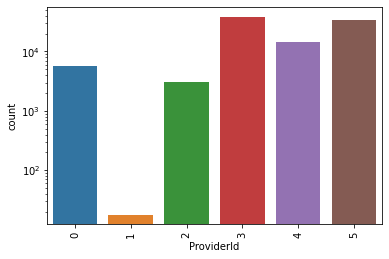

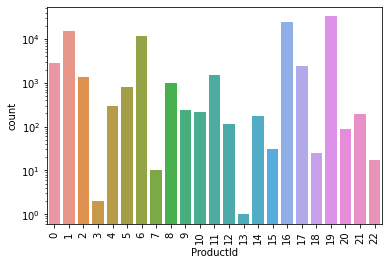

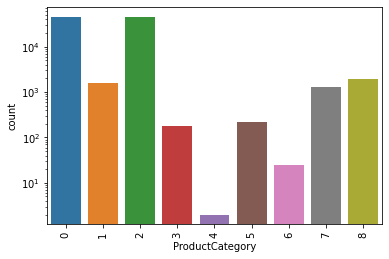

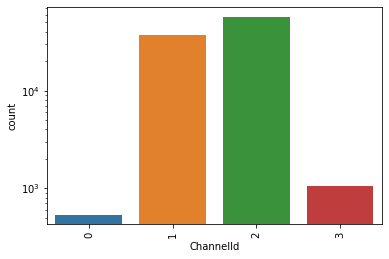

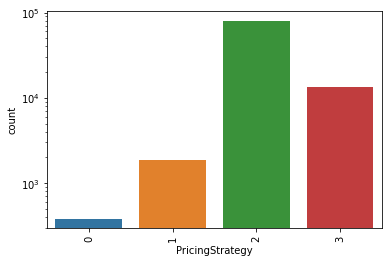

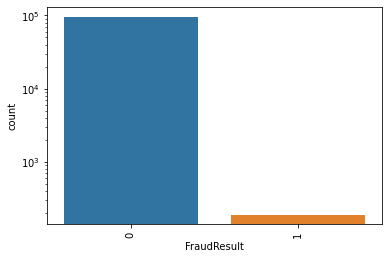

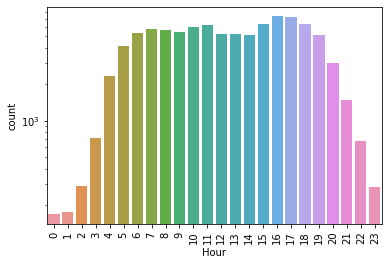

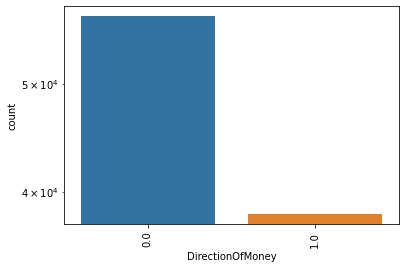

In [341]:
# univariate distributions
for c in data[['ProviderId', 'ProductId','ProductCategory', 'ChannelId','PricingStrategy', 'FraudResult', 'Hour','DirectionOfMoney']].columns:
        plt.figure()
        sns.countplot(data[c])
        plt.xticks(rotation=90)
        plt.yscale('log')


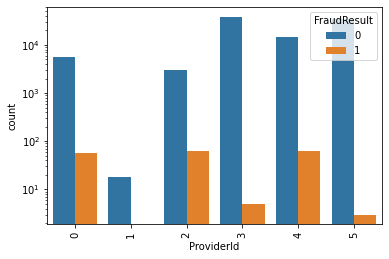

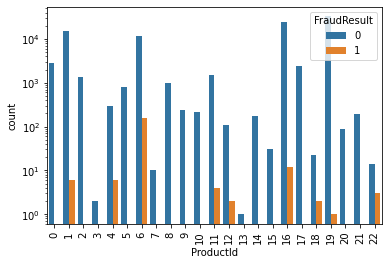

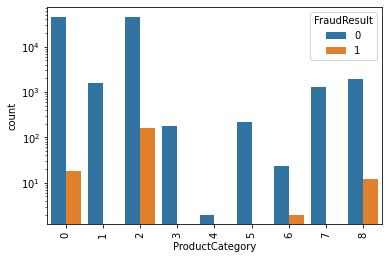

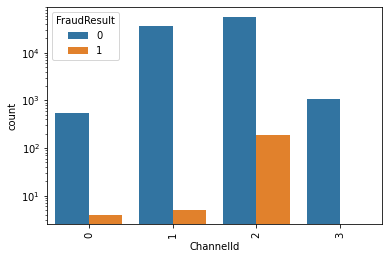

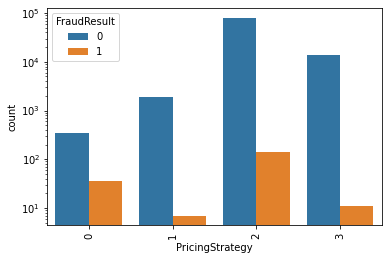

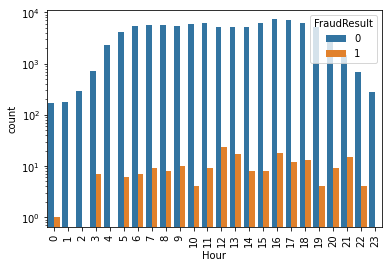

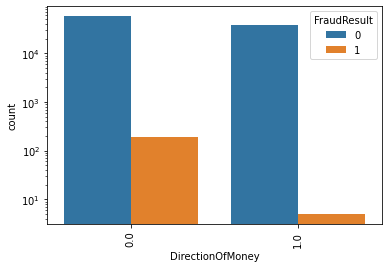

In [342]:
# bivartiate distrobution
for c in data[['ProviderId', 'ProductId','ProductCategory', 'ChannelId','PricingStrategy', 'Hour','DirectionOfMoney']].columns:
        plt.figure()
        #g = sns.FacetGrid(data = data,  col = 'FraudResult')
        sns.countplot(x=c, hue='FraudResult', data = data)
        #g.map(sns.countplot, x = c)
        plt.xticks(rotation=90)
        plt.yscale('log')

#g = sns.FacetGrid(data[['ProviderId', 'ProductId','ProductCategory', 'ChannelId','PricingStrategy', 'FraudResult', 'Hour','DirectionOfMoney', 'FraudResult']], 
#'FraudResult')
#g.map(sns.catplot, 


In [343]:
# creating new column for the log of value (to erase outliers)
#df['Valuelog'] = np.log(df['Value'])
#data['Valuelog'] = np.log(data['Value'])


In [344]:
#plt.hist(df['Valuelog'], bins=25)
#plt.yscale('log')

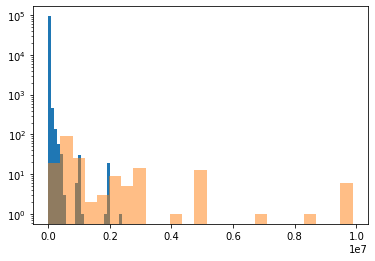

In [345]:
import matplotlib.pyplot as plt
plt.hist(data.loc[data['FraudResult'] == 0,'Value'], bins=25)
plt.yscale('log')
plt.hist(data.loc[data['FraudResult'] == 1,'Value'], bins=25, alpha = 0.5)
plt.yscale('log')
plt.show()



In [346]:
df.columns

Index(['Value', 'DirectionOfMoney', 'ProviderId_0', 'ProviderId_1',
       'ProviderId_2', 'ProviderId_3', 'ProviderId_4', 'ProviderId_5',
       'ProductId_0', 'ProductId_1', 'ProductId_2', 'ProductId_3',
       'ProductId_4', 'ProductId_5', 'ProductId_6', 'ProductId_7',
       'ProductId_8', 'ProductId_9', 'ProductId_10', 'ProductId_11',
       'ProductId_12', 'ProductId_13', 'ProductId_14', 'ProductId_15',
       'ProductId_16', 'ProductId_17', 'ProductId_18', 'ProductId_19',
       'ProductId_20', 'ProductId_21', 'ProductId_22', 'ProductId_23',
       'ProductId_24', 'ProductId_25', 'ChannelId_0', 'ChannelId_1',
       'ChannelId_2', 'ChannelId_3', 'ChannelId_4', 'ProductCategory_0',
       'ProductCategory_1', 'ProductCategory_2', 'ProductCategory_3',
       'ProductCategory_4', 'ProductCategory_5', 'ProductCategory_6',
       'ProductCategory_7', 'ProductCategory_8', 'PricingStrategy_0',
       'PricingStrategy_1', 'PricingStrategy_2', 'PricingStrategy_3', 'Hour_0',
       'Hour_

In [347]:
# # initialising first very simple basline model, every transaction used for financial services is predicte to be fradulent
# #used the great method kat showed us
# df.loc[df['ProductCategory_financial_services'] == 1, 'Prediction'] = 1
# df.loc[df['ProductCategory_financial_services'] != 1, 'Prediction'] = 0
# predictions = df.Prediction
# df = df.drop('Prediction', axis=1)

In [348]:
# condition1 = df['ProductCategory_financial_services'] == 1
# condition2 = df['DirectionOfMoney'] == 0
# condition3 = df['ChannelId_ChannelId_3'] == 1
# condition4 = (df['PricingStrategy'] == 0) | (df['PricingStrategy'] == 2)
# condition5 = df["ProductId_ProductId_15"] == 1
# condition6 = (df['ProviderId_ProviderId_1'] == 1) | (df['ProviderId_ProviderId_3'] == 1)| (df['ProviderId_ProviderId_5'] == 1)
# condition7 = df['Value'] >= 200000
# predictions = condition1 & condition2 & condition3 & condition4 & condition5 & condition6 & condition7
# #printing scores for baseline
#print_evaluations(y, predictions)


In [349]:
#defining X and y
X = df
y = data['FraudResult']
X.to_csv("data/X.csv")  
y.to_csv("data/y.csv")  
data_test['TransactionId'] = test_id
data_test.to_csv('data/X_test.csv')